In [1]:
import numpy as np
import matplotlib.pyplot as plt



In [3]:
class MultiArmedBandit:
    def __init__(self, k=10, nonstationary=False):
        self.k = k  # Number of arms
        self.q_true = np.random.normal(0, 1, k)  # True reward values
        self.n = np.zeros(k)  # Action counts
        self.q_est = np.zeros(k)  # Estimated values
        self.nonstationary = nonstationary
    
    def step(self, action):
        if self.nonstationary:
            self.q_true += np.random.normal(0, 0.01, self.k)  # Nonstationary drift
        reward = np.random.normal(self.q_true[action], 1)  # Reward
        self.n[action] += 1
        return reward



In [5]:
def epsilon_greedy(bandit, steps=1000, epsilon=0.1, alpha=None):
    rewards = np.zeros(steps)
    for t in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(bandit.k)  # Explore
        else:
            action = np.argmax(bandit.q_est)  # Exploit
        reward = bandit.step(action)
        rewards[t] = reward
        if alpha is None:
            bandit.q_est[action] += (reward - bandit.q_est[action]) / bandit.n[action]
        else:
            bandit.q_est[action] += alpha * (reward - bandit.q_est[action])
    return rewards



In [7]:
def optimistic_initial_values(bandit, steps=1000, initial_value=5):
    bandit.q_est = np.ones(bandit.k) * initial_value
    return epsilon_greedy(bandit, steps, epsilon=0)



In [9]:
def ucb(bandit, steps=1000, c=2):
    rewards = np.zeros(steps)
    for t in range(steps):
        if 0 in bandit.n:
            action = np.argmin(bandit.n)
        else:
            ucb_values = bandit.q_est + c * np.sqrt(np.log(t+1) / bandit.n)
            action = np.argmax(ucb_values)
        reward = bandit.step(action)
        rewards[t] = reward
        bandit.q_est[action] += (reward - bandit.q_est[action]) / bandit.n[action]
    return rewards



In [11]:
def gradient_bandit(bandit, steps=1000, alpha=0.1):
    H = np.zeros(bandit.k)
    rewards = np.zeros(steps)
    for t in range(steps):
        policy = np.exp(H) / np.sum(np.exp(H))
        action = np.random.choice(bandit.k, p=policy)
        reward = bandit.step(action)
        rewards[t] = reward
        baseline = np.mean(rewards[:t+1])
        H -= alpha * (reward - baseline) * policy  # Update preferences
        H[action] += alpha * (reward - baseline) * (1 - policy[action])
    return rewards



In [13]:
def associative_search(steps=1000, states=5):
    bandits = [MultiArmedBandit(k=10) for _ in range(states)]
    rewards = np.zeros(steps)
    for t in range(steps):
        state = np.random.randint(states)
        rewards[t] = np.mean(epsilon_greedy(bandits[state], steps=1, epsilon=0.1))
    return rewards



In [17]:
# Running experiments
bandit = MultiArmedBandit(k=10, nonstationary=True)
steps = 1000



In [19]:
rewards_eps_greedy = epsilon_greedy(bandit, steps, epsilon=0.1, alpha=0.1)
rewards_optimistic = optimistic_initial_values(bandit, steps, initial_value=5)
rewards_ucb = ucb(bandit, steps, c=2)
rewards_gradient = gradient_bandit(bandit, steps, alpha=0.1)
rewards_associative = associative_search(steps=steps)



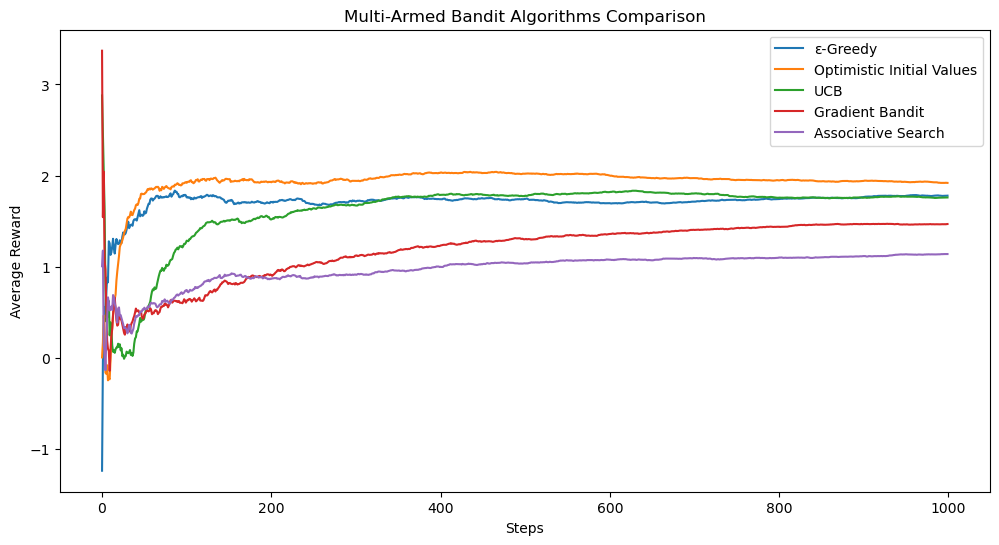

In [21]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(rewards_eps_greedy) / np.arange(1, steps+1), label='ε-Greedy')
plt.plot(np.cumsum(rewards_optimistic) / np.arange(1, steps+1), label='Optimistic Initial Values')
plt.plot(np.cumsum(rewards_ucb) / np.arange(1, steps+1), label='UCB')
plt.plot(np.cumsum(rewards_gradient) / np.arange(1, steps+1), label='Gradient Bandit')
plt.plot(np.cumsum(rewards_associative) / np.arange(1, steps+1), label='Associative Search')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.title('Multi-Armed Bandit Algorithms Comparison')
plt.show()
